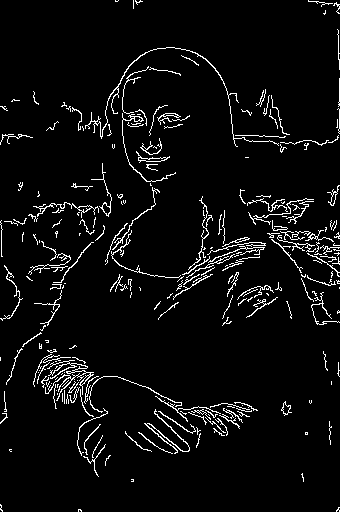

In [6]:
import cv2
from PIL import Image
import numpy as np
from diffusers.utils import load_image

image = load_image(
    "monalisa.jpg"
)
size = (340, 512)
image = image.resize(size)
image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
canny_image

# Fully-trained SD 1.5

In [13]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch


controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny",
                                             torch_dtype=torch.float32).to("cuda")

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "./output_dir",
    controlnet=controlnet,
    torch_dtype=torch.float32).to("cuda")

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# pipe.enable_xformers_memory_efficient_attention()

Loading pipeline components...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 21.62it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.25it/s]


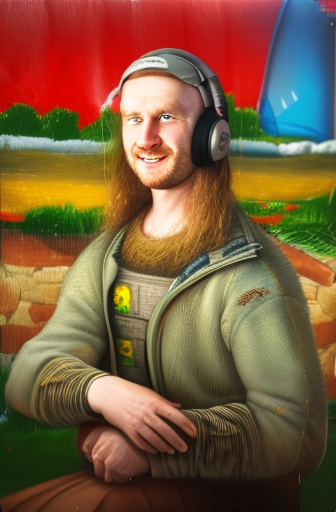

In [14]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

generator = torch.manual_seed(2)
prompt = "portrait of sks man face, best quality, extremely detailed"
output = pipe(
    prompt,
    canny_image,
    negative_prompt="monochrome, lowres, bad anatomy, worst quality, low quality, nsfw, adult content, woman, female",
    generator=generator,
    num_inference_steps=20,
)

output.images[0]

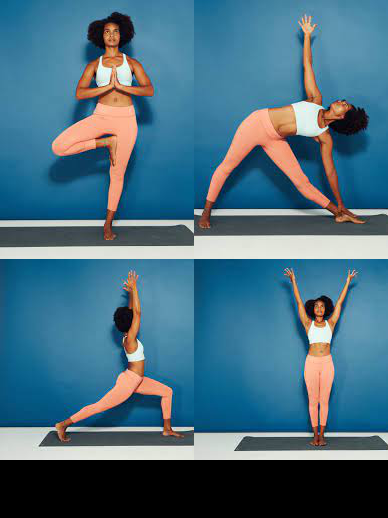

In [8]:
urls = "yoga1.jpeg", "yoga2.jpeg", "yoga3.jpeg", "yoga4.jpeg"
imgs = [load_image("https://hf.co/datasets/YiYiXu/controlnet-testing/resolve/main/" + url) for url in urls]

image_grid(imgs, 2, 2)

/home/peter/anaconda3/envs/torch_generative/lib/python3.10/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(
Loading pipeline components...:  43%|████████████████████████████████████████████████████████████▍                                                                                | 3/7 [00:00<00:00, 23.79it/s]/home/peter/anaconda3/envs/torch_generative/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
Loading pipeline components...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:0

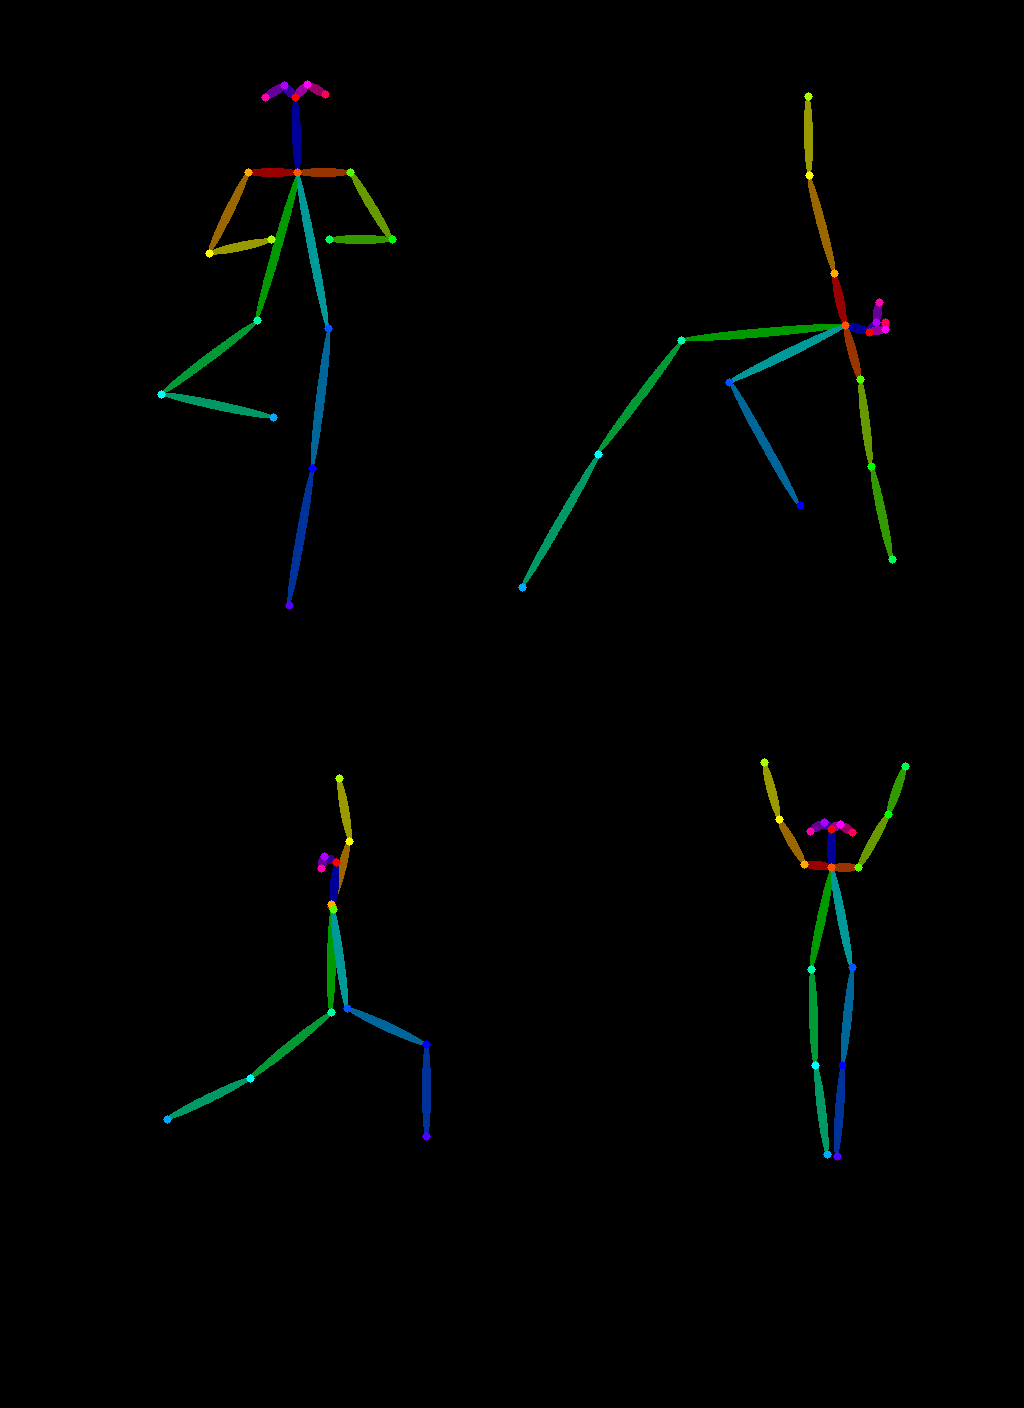

In [9]:
from controlnet_aux import OpenposeDetector

model = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

controlnet = ControlNetModel.from_pretrained("fusing/stable-diffusion-v1-5-controlnet-openpose", torch_dtype=torch.float32)

pipe = StableDiffusionControlNetPipeline.from_pretrained("./output_dir", controlnet=controlnet, torch_dtype=torch.float32,).to("cuda")
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

poses = [model(img) for img in imgs]
image_grid(poses, 2, 2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.04s/it]


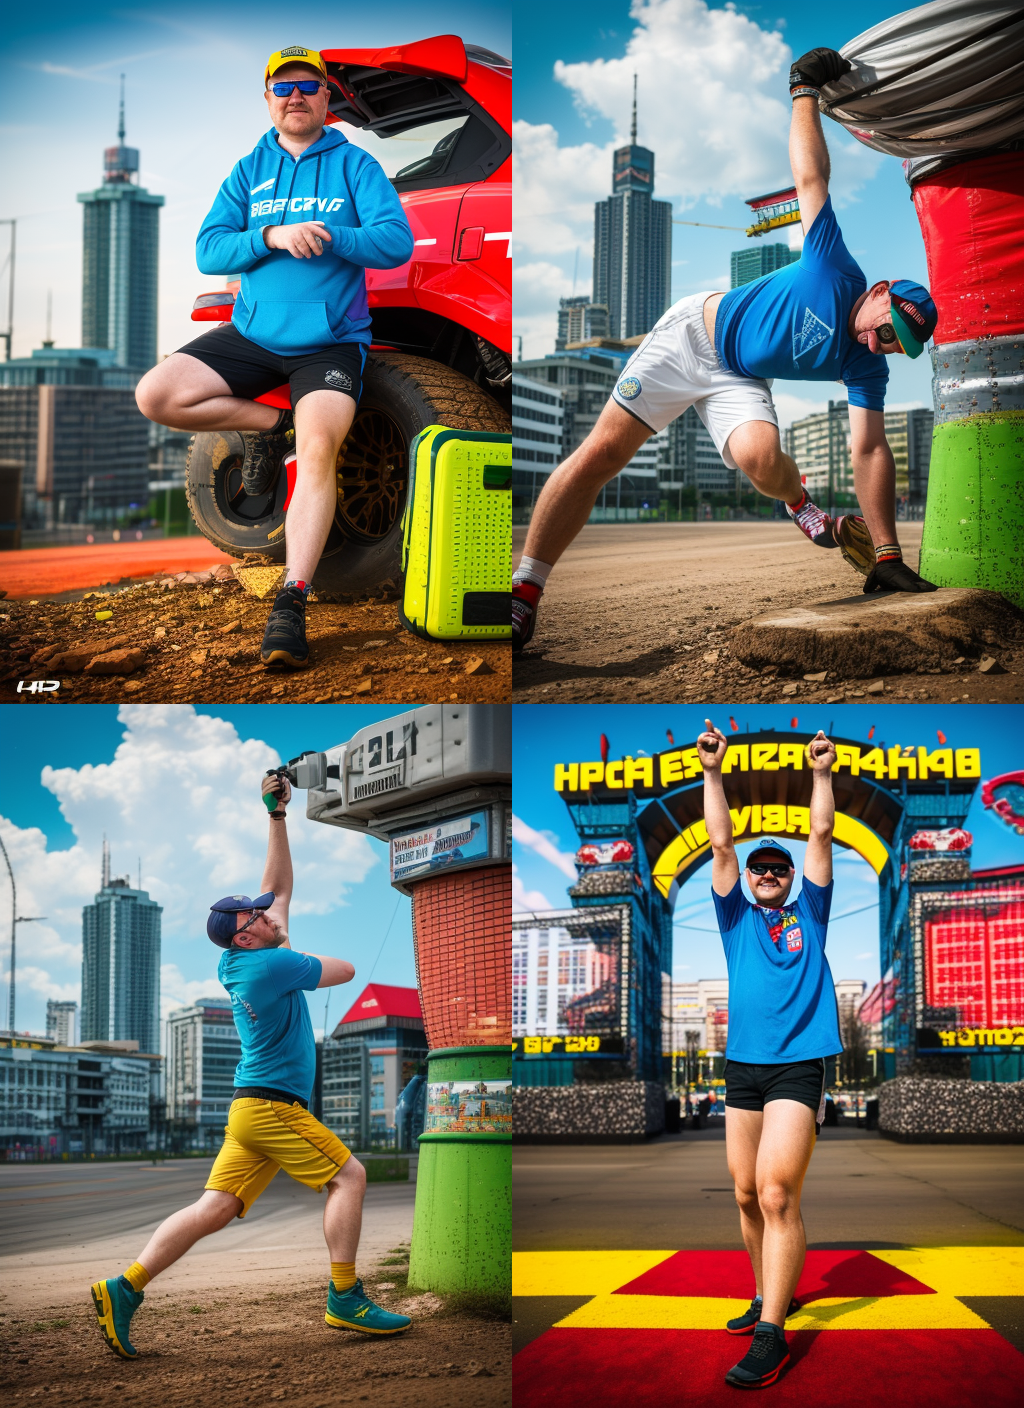

In [10]:
generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(4)]
prompt = "a photo of sks man, best quality, extremely detailed, sharp focus, 4k, hdr, high quality"
output = pipe(
    [prompt] * 4,
    poses,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality, nsfw, adult content"] * 4,
    generator=generator,
    num_inference_steps=20,
)
image_grid(output.images, 2, 2)

# LoRA

In [19]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch


controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny",
                                             torch_dtype=torch.float32).to("cuda")

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "./model",
    controlnet=controlnet,
    torch_dtype=torch.float32).to("cuda")
pipe.load_lora_weights("./lora_outputs/r64/checkpoint-150/pytorch_lora_weights.safetensors")

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# pipe.enable_xformers_memory_efficient_attention()

Loading pipeline components...:   0%|                                                                                                                                                     | 0/7 [00:00<?, ?it/s]/home/peter/anaconda3/envs/torch_generative/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Loading pipeline components...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  3.46it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.84it/s]


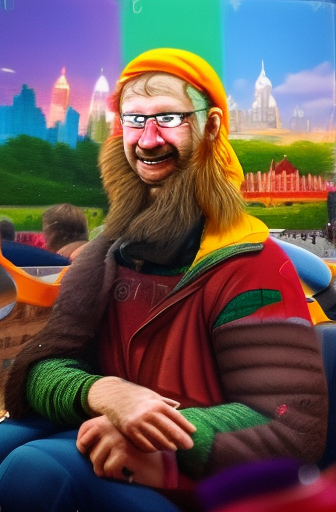

In [20]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

generator = torch.manual_seed(0)
prompt = "portrait of sks man face, best quality, extremely detailed"
output = pipe(
    prompt,
    canny_image,
    negative_prompt="monochrome, lowres, bad anatomy, worst quality, low quality, nsfw, adult content, woman, female",
    generator=generator,
    num_inference_steps=20,
)

output.images[0]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.08s/it]


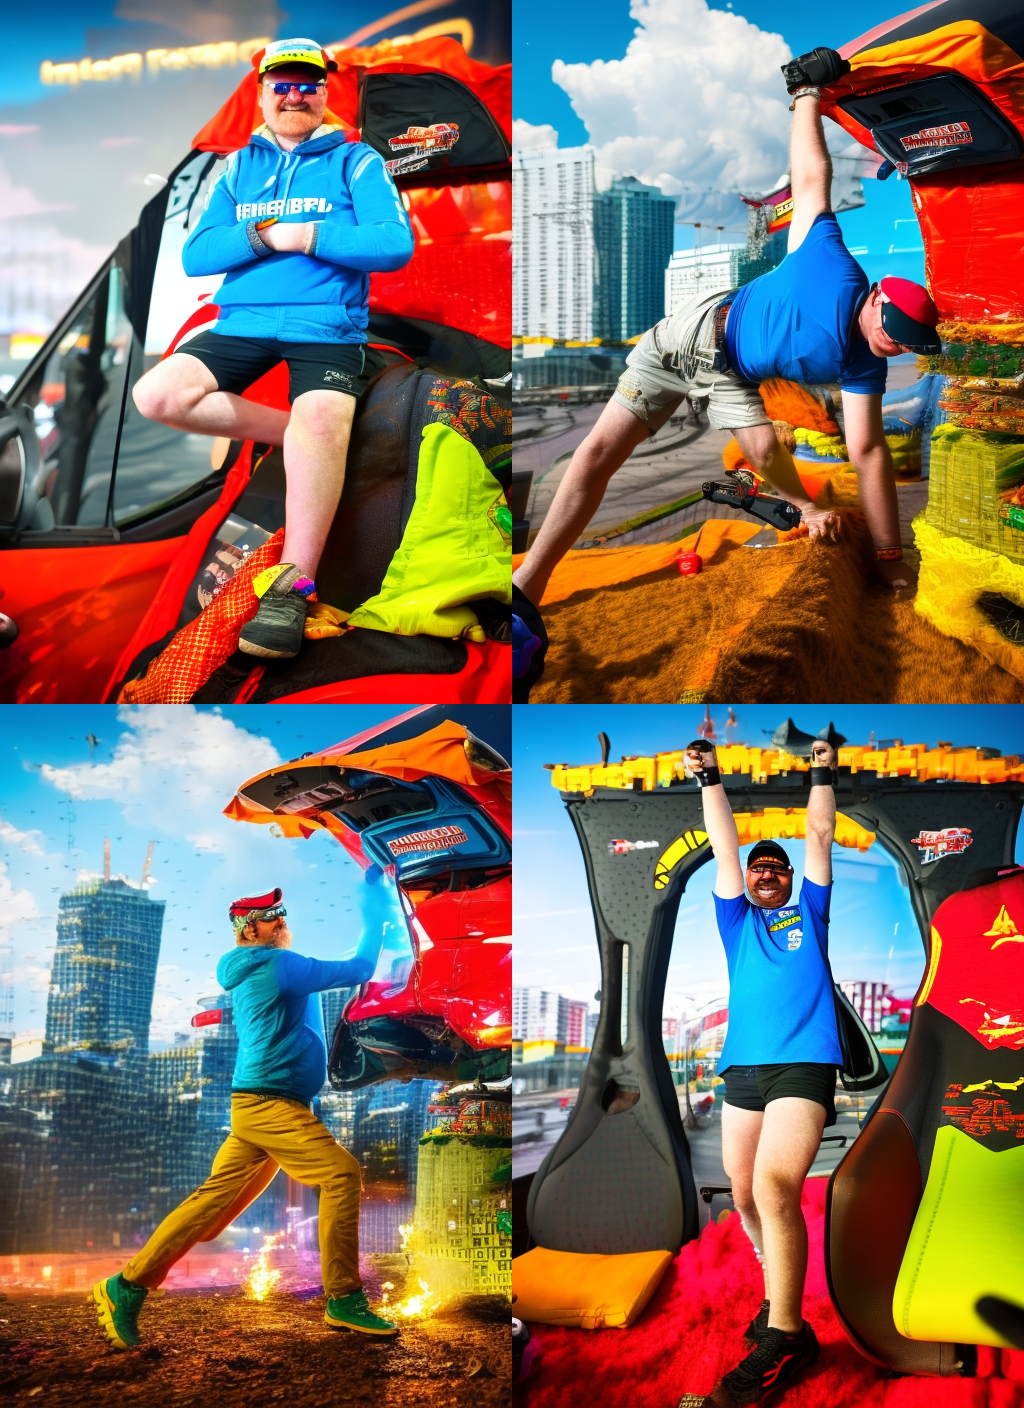

In [21]:
from controlnet_aux import OpenposeDetector

model = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

controlnet = ControlNetModel.from_pretrained("fusing/stable-diffusion-v1-5-controlnet-openpose", torch_dtype=torch.float32)

pipe = StableDiffusionControlNetPipeline.from_pretrained("./output_dir", controlnet=controlnet, torch_dtype=torch.float32,).to("cuda")
pipe.load_lora_weights("./lora_outputs/r64/checkpoint-150/pytorch_lora_weights.safetensors")
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(4)]
prompt = "a photo of sks man, best quality, extremely detailed, sharp focus, 4k, hdr, high quality"
output = pipe(
    [prompt] * 4,
    poses,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality, nsfw, adult content"] * 4,
    generator=generator,
    num_inference_steps=20,
)
image_grid(output.images, 2, 2)